#### Tutorial 3:  Regularization Approaches

In this notebook, we will investigate several regularization techniques namely Elastic Weight Consolidation and Knowledge distilation. If you haven't already observed it, models usually suffer from the problem of catastrophic forgetting when trained on a sequence of tasks. That is, it forgets the past information while learning the new information. EWC and Knowledge Distillation are two such approaches that helps us maintain the stability and plasticity of the model. 

Reference paper:  [EWC](https://arxiv.org/abs/2502.11756) , [Knowledge Distillation](https://amit-s.medium.com/everything-you-need-to-know-about-knowledge-distillation-aka-teacher-student-model-d6ee10fe7276)


In [ ]:
#!pip install torchvision==0.18.0 
!pip show torch torchvision
import torch 
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm
from torchvision.models import resnet18
import random
import matplotlib.pyplot as plt


#### Loading the dataset

In this notebook, we will be using Mnist and the permuted version of Mnist dataset. 

-- TO-DO --
- First, download the Mnist dataset from torchvision and define the dataset object. 

In [2]:
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
mean = torch.tensor([0.4589, 0.4384, 0.4011])
std = torch.tensor([0.2793, 0.2724, 0.2835])

# Apply transforms
#transforms = transforms.Compose(
#    [transforms.ToTensor()
#    ])

mnist_trainset = datasets.MNIST(root='/app/src/Mnist', train=True, download=True, transform= transforms.ToTensor())
mnist_testset = datasets.MNIST(root='/app/src/Mnist', train=False, download=True, transform= transforms.ToTensor())

len(mnist_trainset), len(mnist_testset) # 60000, 10000
config = {'size': 28, 'channels': 1, 'classes': 10}


#### Helper function: Visualization

- Provided the visualization function to plot instances belonging to different class 

In [3]:
#@title Visualization functions
def multi_context_barplot(axis, accs, title=None):
    '''Generate barplot using the values in [accs].'''
    contexts = len(accs)
    axis.bar(range(contexts), accs, color='k')
    axis.set_ylabel('Testing Accuracy (%)')
    axis.set_xticks(range(contexts), [f'Context {i+1}' for i in range(contexts)])
    if title is not None:
        axis.set_title(title)

def plot_examples(axis, dataset, context_id=None):
    '''Plot 25 examples from [dataset].'''
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)
    image_tensor, _ = next(iter(data_loader))
    image_grid = make_grid(image_tensor, nrow=5, pad_value=1) # pad_value=0 would give black borders
    axis.imshow(np.transpose(image_grid.numpy(), (1,2,0)))
    if context_id is not None:
        axis.set_title("Context {}".format(context_id+1))
    axis.axis('off')

#### Permuted Mnist 

1. we need to define a function to permute the pixels of a image. 
2. We will basically use the original Mnist dataset samples and pass the function over each samples to create our Mnist dataset. 

In [4]:
# Function to apply a given permutation the pixels of an image.
def permutate_image_pixels(image, permutation):
    '''Permutate the pixels of [image] according to [permutation].'''
        """ -- TODO -- """ 

        return image
    
# Class to create a dataset with images that have all been transformed in the same way.
class TransformedDataset(torch.utils.data.Dataset):
    '''To modify an existing dataset with a transform.
    Useful for creating different permutations of MNIST without loading the data multiple times.'''

    def __init__(self, original_dataset, transform=None, target_transform=None):
        super().__init__()
        self.dataset = original_dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        (input, target) = self.dataset[index]
        if self.transform:
            input = self.transform(input)
        if self.target_transform:
            target = self.target_transform(target)
        return (input, target)

#### Define the sequential tasks

-- TO-DO --
1. We will use only two tasks in this notebook,  denoted as contexts. 
2. We will use the "full" Mnist datasset as our first task and the permuted Mnist dataset as our second task. 

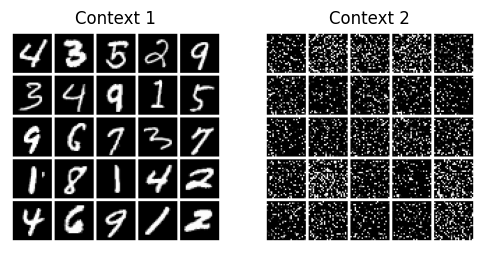

In [ ]:
import numpy as np
contexts = 2 
permutations = [None] + [np.random.permutation(config['size']**2) for _ in range(contexts-1)]
# Specify for each context the transformed train- and testset
train_datasets = []
test_datasets = []
for context_id, perm in enumerate(permutations):
    train_datasets.append(TransformedDataset(
        mnist_trainset, transform=transforms.Lambda(lambda x, p=perm: permutate_image_pixels(x, p)),
    ))
    test_datasets.append(TransformedDataset(
        mnist_testset, transform=transforms.Lambda(lambda x, p=perm: permutate_image_pixels(x, p)),
    ))

# Visualize the contexts
figure, axis = plt.subplots(1, contexts, figsize=(3*contexts, 4))

for context_id in range(len(train_datasets)):
    plot_examples(axis[context_id], train_datasets[context_id], context_id=context_id)


#### Model definition

1. Define a simple MLP based network
    - It may only consist of 2-3 linear layers in total with output node of 10; as we have 10 classes in Mnist 
    - As you already know the input shape of Mnist is (1, 28, 28). So, we have to use nn.FLatten() as your first layer if you are using a purely MLP architecture. 
    

In [45]:
#model = models.alexnet(pretrained=False, num_classes=10)
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
 
        return x
    
    

In [ ]:
# Print info regarding number of parameters
model = Net()
model.to('cuda')
total_params = 0
for param in model.parameters():
   
   
print( "--> this network has {} parameters (~{}K)"
      .format(total_params, round(total_params / 1000)))

#model.calculate_fisher_info(train_datasets[0], fisher_labels='exact', fisher_n=100, allowed_classes=None)

#### Initialize the Fischer information matrix 

1. It should be of the shape of the actual model parameters, (model.state_dict()). That means, the information matrix should have placeholders for each layer of the model. 

In [ ]:
def initialize_fisher_info(self):
    params = [model.named_parameters]
    gamma = 1
    data_len = 
        

    est_fisher_info = {}
    for gen_params in params:
        


#### Calculate the Fisher matrix 

We have four choices to create our Fischer information matrix 
- Exact: When we iterate over all the samples and calculate the fischer for each individual samples 
- Exact and Sample: We calculate the fischer for N samples 
- True: When we calculate the fischer based on the true class 
- Predicted: When we calculate the fischer based on the predicted class 

Store the values in the previously initialized network. 

In [ ]:
def calculate_fisher_info( train_set, fisher_labels='exact', fisher_n=None, allowed_classes=None):
    randomize_fisher = False
    # -only use one particular label for each datapoint
    model.eval()
    train_ = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False)
    for index,(x,label) in tqdm(enumerate(train_)):
        # break from for-loop if max number of samples has been reached
        #if index == 100:
        #    break
        #if fisher_labels == 'n_samples':
        if fisher_n is not None:
            if index > fisher_n:
                break
        x, label = x.to('cuda'), label.to('cuda')
        output = model(x) 
        if fisher_labels == 'exact':
            
        else:
            if fisher_labels=='true':
                
                
            elif fisher_labels=='pred':
                # --> use predicted label to calculate loglikelihood:

           
            # calculate negative log-likelihood
            
            # calculate gradient of negative loglikelihood

            # square gradients and keep running sum
            

    est_fisher_info = {n: p/index for n, p in est_fisher_info.items()}
    

    
    return est_fisher_info


### Define the EWC loss

Implement the function to define the EWC loss. 
the EWC regularization term is given by:
$$
\mathcal{L}^{(k)}_{\text{regularization}_{\text{EWC}}}\left(\boldsymbol{\theta}\right) = \frac{1}{2} \sum_{i=1}^{N_{\text{params}}} \tilde{F}_{ii}^{(k)} \left(\theta_i - \hat{\theta}_{i}^{(k)} \right)^2
$$
whereby $\hat{\theta}_{i}^{(k)}$ is the $i^{\text{th}}$ element of $\hat{\boldsymbol{\theta}}^{\left(k\right)}$, which is the vector with parameter values at the end of training of task $k$, and $\tilde{F}_{ii}^{(k)}$ is an approximation of $F_{ii}^{(k)}$, the $i^{\text{th}}$ diagonal element of $\boldsymbol{F}^{(k)}$, which is the Fisher Information matrix of task $k$ evaluated at $\hat{\boldsymbol{\theta}}^{(k)}$.

In [14]:
def ewc_loss():

    return 

#### Sequential training with EWC

#### Define the training and the validation function

In [52]:
import os

#optimizer = optim.Adam(model.parameters(), lr=0.01)
def train_model(model,  train_loader, optimizer, criterion, task, ewc= False, num_epochs=1):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if ewc == True:
                loss += 100. * ewc_loss()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            acc = (outputs.argmax(dim=1) == labels).float().mean()
            running_acc += acc.item()
            # Print statistics

        #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {running_acc/len(train_loader):.4f}")

        #test_model(model, test_loader[task], criterion)
    if not os.path.exists('/app/src/output'):
        os.makedirs('/app/src/output')
    torch.save(model.state_dict(), f'/app/src/output/model_task_{task}.pth')

def test_model(model, test_loader, criterion, context= 0):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            acc = (outputs.argmax(dim=1) == labels).float().mean()
            running_acc += acc.item()
    #print(f"Test Loss: {running_loss/len(test_loader):.4f}")
    print(f"Test Accuracy of context {context} is: {running_acc/len(test_loader):.4f}")

##### Train on first context

- Let's the train the model on the first context 


In [49]:
model.to('cuda')
loader = torch.utils.data.DataLoader(train_datasets[0], batch_size=128, shuffle=True)
train_model(model, loader, optimizer, loss, task= 0,ewc= False, num_epochs=2)
#model.calculate_fisher_info(train_dataset[0], fisher_labels='all', fisher_n=None, allowed_classes=None)
    

Epoch [1/2], Accuracy: 0.9309
Epoch [2/2], Accuracy: 0.9643


1. Evaluate the model on both the contexts and report the accuracy. 
- you should see a performance degradation on the second task which is normal as it hasnot been trained on it

In [50]:
contexts = 2
for i in range(contexts):
    test_loader = torch.utils.data.DataLoader(test_datasets[i], batch_size=128, shuffle=False)

    test_model(model, test_loader, loss , context= i)

Test Accuracy of context 0 is: 0.9658
Test Accuracy of context 1 is: 0.0922


##### Train on context 2

- Now train on the context 2 and evaluate the model on both the contexts. You should observe a performance degradation on the context 1. Signalling Catastrophic Forgetting !!!

In [67]:
model.load_state_dict(torch.load('/app/src/output/model_task_0.pth'))
optimizer = optim.Adam(model.parameters(), lr=0.01)
loader = torch.utils.data.DataLoader(train_datasets[1], batch_size=128, shuffle=True)
train_model(model, loader, optimizer, loss, task= 1,ewc= False, num_epochs=2)

/tmp/ipykernel_4655/1301658764.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/app/src/output/model_task_0.pth'))


Epoch [1/2], Accuracy: 0.9220
Epoch [2/2], Accuracy: 0.9625


In [68]:
contexts = 2
for i in range(contexts):
    test_loader = torch.utils.data.DataLoader(test_datasets[i], batch_size=128, shuffle=False)

    test_model(model, test_loader, loss , context= i)

Test Accuracy of context 0 is: 0.6615
Test Accuracy of context 1 is: 0.9636


#### EWC: Sequentially train the model with EWC

- Now Train the model on the first task and save it. 
- Calculate the Fischer matrix using the model from the first context 
- Now train the train the model on the context 2 using EWC loss. 


In [60]:
model_ = Net()
model_.load_state_dict(torch.load('/app/src/output/model_task_0.pth'))
dict_ = torch.load('/app/src/output/model_task_0.pth')

Now Evaluate the model on two contexts

#### Knowledge Distillation

For KD, we need a teacher model which we will use it to infer knowledge from. 
- So first, perform a joint training and save it a teacher model

In [159]:
torch.save(model.state_dict(), '/app/src/output/model_teacher.pth')

##### Define your training loop with KD loss



In [ ]:
def train(model, criterion, train_loader, task, num_epochs=1, kd=False):
    model.train()
    #loader_ = train_loader[0]
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0
        loader_ = iter(train_loader)
        for i, (inputs, labels) in enumerate(train_loader[task]):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if kd == True:
                with torch.no_grad():
                    
                    """ TODO """

                    
                loss += kd_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            acc = (outputs.argmax(dim=1) == labels).float().mean()
            running_acc += acc.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {running_acc/len(train_loader):.4f}")

        test_model(model, test_loader[task], criterion)
    #if not os.path.exists('/app/src/output'):
    #    os.makedirs('/app/src/output')
    #torch.save(model.state_dict(), f'/app/src/output/model_task_{task}.pth')

def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            acc = (outputs.argmax(dim=1) == labels).float().mean()
            running_acc += acc.item()
    #print(f"Test Loss: {running_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {running_acc/len(test_loader):.4f}")


### Train and Evaluate your model on two contexts. 